In [26]:
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from psis import *

import stan
import nest_asyncio
nest_asyncio.apply()

In [27]:
df = pd.read_csv("../data/02-processed/normalized_data.csv")
df.dropna(inplace=True)
df

,SUBJID,SATMath,SATWriting,SATVerbal,GPA,state,gender,race,income,choice,accepted,school,numapply,habits,SAT
0,884230,-1.652536,-1.777725,-1.719744,-0.688423,AL,Female,Black,4.439333,4.0,1.0,2192.0,9,6,-1.918234
1,884232,-1.845287,-1.681540,-1.324951,-2.113622,AL,Male,Black,4.243038,1.0,1.0,2192.0,6,6,-1.809764
2,884233,-1.845287,-2.739570,-2.805425,-3.776353,AL,Male,Black,4.653213,4.0,0.0,2192.0,4,4,-2.749835
3,884247,-0.592404,-0.623510,-0.239270,0.974309,AL,Female,Black,4.096910,1.0,1.0,2192.0,9,8,-0.544284
4,884307,-0.977906,-0.334957,-0.930158,-0.688423,AL,Male,Black,4.096910,4.0,1.0,2192.0,9,7,-0.833536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91259,886635,-3.098170,-1.008248,-2.015839,0.261710,FL,Female,Two or more race/ethnicity,5.397940,1.0,1.0,1691.0,6,5,-2.279800
91260,886640,0.467728,0.530704,0.451618,0.261710,FL,Female,White,4.942008,1.0,1.0,1691.0,3,7,0.540414
91261,886642,-0.110526,1.684918,1.339902,0.974309,FL,Female,Two or more race/ethnicity,4.829304,1.0,1.0,1691.0,9,6,1.082762
91262,886648,-0.399653,-0.912064,-0.535365,-0.688423,FL,Male,White,4.829304,2.0,1.0,1691.0,6,7,-0.688910


In [28]:
outcome_col = ["accepted"]
dummy_cols = ["gender", "race"]
cols_to_exclude =["choice", "SUBJID", "SATMath", "SATWriting", "SATVerbal", "state", "school", "habits"] 

# Get dummy columns
dummy_df = pd.get_dummies(df[dummy_cols], prefix='', prefix_sep='', dummy_na=False, dtype=np.int8)
dummy_school = pd.get_dummies(df["school"])

# Get response column
Y = df[outcome_col]

X = df.drop(outcome_col + dummy_cols + cols_to_exclude, axis=1).copy()
X = pd.concat([X, dummy_df, dummy_school], axis=1)

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(
    X,
    Y,
    train_size=10_000,
    test_size=10_000,
    random_state=17)

In [29]:
# Convert dataframes to np arrays
X_train = X_train_df.copy().to_numpy()
X_test  = X_test_df.copy().to_numpy()
y_train = y_train_df.copy().astype(np.int8).to_numpy().flatten()
y_test = y_test_df.copy().astype(np.int8).to_numpy().flatten()

In [30]:
logistic_regression_code = """
/**
 * Logistic regression t-prior
 *
 * Priors:
 *     weights - student t
 *     intercept - student t
 */
data {
    int n;                        // number of data points
    int d;                        // explanatory variable dimension
    matrix[n, d] X;               // explanatory variable
    array[n] int <lower=0, upper=1> y;  // response variable
    int<lower=1> p_alpha_df;      // prior degrees of freedom for alpha
    real p_alpha_loc;             // prior location for alpha
    real p_alpha_scale;           // prior scale for alpha
    int<lower=1> p_beta_df;       // prior degrees of freedom for beta
    real p_beta_loc;     // prior location for beta
    real p_beta_scale;            // prior scale for beta

    int<lower=0> N_new;
    matrix[N_new, d] X_new;
}
parameters {
    real alpha;      // intercept
    vector[d] beta;  // explanatory variable weights
}
transformed parameters {
    vector[n] eta;  // linear predictor
    eta = alpha + X * beta;
}
model {
    alpha ~ student_t(p_alpha_df, p_alpha_loc, p_alpha_scale);
    beta ~ student_t(p_beta_df, p_beta_loc, p_beta_scale);
    y ~ bernoulli_logit(eta);
}
generated quantities {
    // calculate the log likelihood
    vector[n] log_lik;
    for (i in 1:n)
        log_lik[i] = bernoulli_logit_lpmf(y[i] | eta[i]);

    // generate values for Y tilde
    array[n] int<lower=0, upper=1> Y_tilde;
    Y_tilde = bernoulli_logit_rng(eta);

    // Make predictions
    vector[N_new] y_new;
    for (j in 1:N_new) {
        y_new[j] = bernoulli_logit_rng(alpha + X_new[j] * beta);
    }
}
"""



In [31]:
# Initialize data dictionary

n = X_train.shape[0]
d = X_train.shape[1]
degf = d - 1
data_dict = dict(
    n=n,                # num data points
    d=d,                # num features
    X=X_train,                # data matrix  
    y=y_train,                # response variable
    p_alpha_df=degf,   # prior deg freedom for alpha
    p_alpha_loc=0,      # prior location for alpha
    p_alpha_scale=5,  # prior scale for alpha
    p_beta_df=degf,    # prior deg freedom for beta
    p_beta_loc=0,       # prior location for beta
    p_beta_scale=5,    # prior scale for beta
    N_new=X_test.shape[0],
    X_new=X_test
)

In [32]:
logistic_regression = stan.build(logistic_regression_code, data=data_dict)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [33]:
# 21 min to run
# 2hrs to run
fit = logistic_regression.sample()

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Samplin

In [34]:
az_fit = az.from_pystan(fit)

## Diagnostics

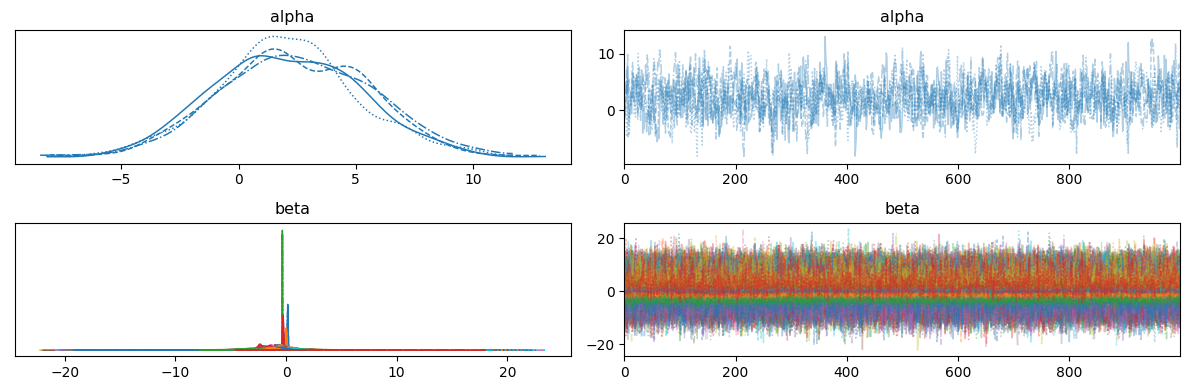

In [35]:
az.plot_trace(az_fit, var_names=["alpha", "beta"])
plt.tight_layout()
plt.show();

In [36]:
# Use arviz to compute the loo elpd
az.loo(az_fit, pointwise=True)

/home/mitch/.local/lib/python3.9/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 by 10000 log-likelihood matrix

         Estimate       SE
elpd_loo -5107.56    57.47
p_loo      373.27        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     9843   98.4%
 (0.5, 0.7]   (ok)         79    0.8%
   (0.7, 1]   (bad)        68    0.7%
   (1, Inf)   (very bad)   10    0.1%

## Results

In [37]:
summary_table = az.summary(az_fit, var_names=["alpha", "beta"])
summary_table.index = ["Intercept"] + list(X_train_df.columns)
summary_table

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.250,3.192,-3.647,8.310,0.103,0.073,962.0,1600.0,1.00
GPA,0.148,0.031,0.090,0.206,0.001,0.000,3226.0,3014.0,1.00
income,0.001,0.061,-0.116,0.113,0.001,0.001,4100.0,3187.0,1.00
numapply,-0.337,0.011,-0.358,-0.315,0.000,0.000,3700.0,2985.0,1.00
SAT,-0.274,0.040,-0.350,-0.199,0.001,0.001,2260.0,2725.0,1.00
...,...,...,...,...,...,...,...,...,...
3083.0,0.438,0.530,-0.548,1.414,0.026,0.019,398.0,1218.0,1.00
3088.0,-0.403,0.535,-1.397,0.604,0.027,0.019,383.0,1302.0,1.01
3107.0,-1.368,0.554,-2.451,-0.378,0.028,0.020,403.0,1941.0,1.00
3138.0,-3.480,1.147,-5.699,-1.358,0.026,0.020,1895.0,2521.0,1.00


In [46]:
summary_table.iloc[:14, :]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.250,3.192,-3.647,8.310,0.103,0.073,962.0,1600.0,1.00
GPA,0.148,0.031,0.090,0.206,0.001,0.000,3226.0,3014.0,1.00
income,0.001,0.061,-0.116,0.113,0.001,0.001,4100.0,3187.0,1.00
numapply,-0.337,0.011,-0.358,-0.315,0.000,0.000,3700.0,2985.0,1.00
SAT,-0.274,0.040,-0.350,-0.199,0.001,0.001,2260.0,2725.0,1.00
Female,1.330,2.976,-4.324,6.899,0.088,0.062,1149.0,1773.0,1.00
Male,0.996,2.978,-4.554,6.661,0.088,0.062,1148.0,1734.0,1.00
American Indian,-0.569,2.059,-4.579,3.101,0.090,0.064,518.0,1257.0,1.01
Asian,-0.312,1.872,-3.799,3.180,0.089,0.063,440.0,975.0,1.01
Black,0.467,1.872,-2.914,4.060,0.089,0.063,441.0,948.0,1.01


In [48]:
for i in range(fit['beta'].shape[0]):
    print(f"{list(X.columns)[i]} : {np.exp(np.mean(fit['beta'][i, :])) - 1}")

GPA : 0.15924798183271527
income : 0.000994598837158689
numapply : -0.2857998048278475
SAT : -0.2398102884570813
Female : 2.7822259844340334
Male : 1.7081799121566767
American Indian : -0.43398236841173243
Asian : -0.26793785975034057
Black : 0.5955188317029629
Hispanic : 0.9180819172969683
Other : 0.5759914485047566
Two or more race/ethnicity : 1.0035264788511737
White : 0.9655003005426712
2.0 : -0.6184150898538268
4.0 : -0.40930399618184765
8.0 : -0.3958107904935635
17.0 : 21.82957187305138
23.0 : -0.4024324641416789
32.0 : -0.8334940110386571
35.0 : 0.6565823930366086
37.0 : 10.191299719760673
39.0 : -0.43680697723647743
48.0 : -0.8805161213947084
51.0 : -0.7826214299550074
57.0 : -0.7560986025751699
58.0 : -0.3617054903045328
69.0 : -0.16970382059328282
70.0 : 0.12821145085276053
72.0 : -0.6261037183991347
73.0 : -0.9872719272810863
76.0 : 0.5749412587159994
87.0 : -0.14984389794097708
88.0 : -0.7069039350457511
100.0 : -0.2735506500950464
102.0 : -0.20729772897360754
117.0 : -0.71

In [50]:
summary_table.iloc[14:, :]["mean"].sort_values()

2192.0   -6.161
1741.0   -6.097
1017.0   -5.735
2041.0   -5.672
2824.0   -5.458
          ...  
547.0     4.368
2761.0    4.414
2717.0    4.443
1678.0    4.661
150.0     4.739
Name: mean, Length: 411, dtype: float64

In [39]:
def plot_betas(fit):
    """Plot the distribution for betas and alpha"""
    n_bins = 100

    plot_range = fit["beta"].shape[0] + 1
    plt.figure(figsize=(8, 50))

    plt.suptitle("Distribution of Coefficients")
    ax1 = plt.subplot(plot_range, 1, 1)
    sns.histplot(fit['alpha'].flatten(), bins=n_bins);
    plt.vlines(0, 0, 150, colors='C1', ls="--")
    plt.ylabel("Intercept")

    for j in range(1, plot_range):
        plt.subplot(plot_range,1, j + 1, sharex=ax1)
        sns.histplot(fit['beta'][j-1,:], bins=n_bins)
        sns.despine()
        plt.ylabel(list(X.columns)[j-1])
        plt.vlines(0, 0, 150, colors='C1', ls="--")

    plt.tight_layout(pad=1)

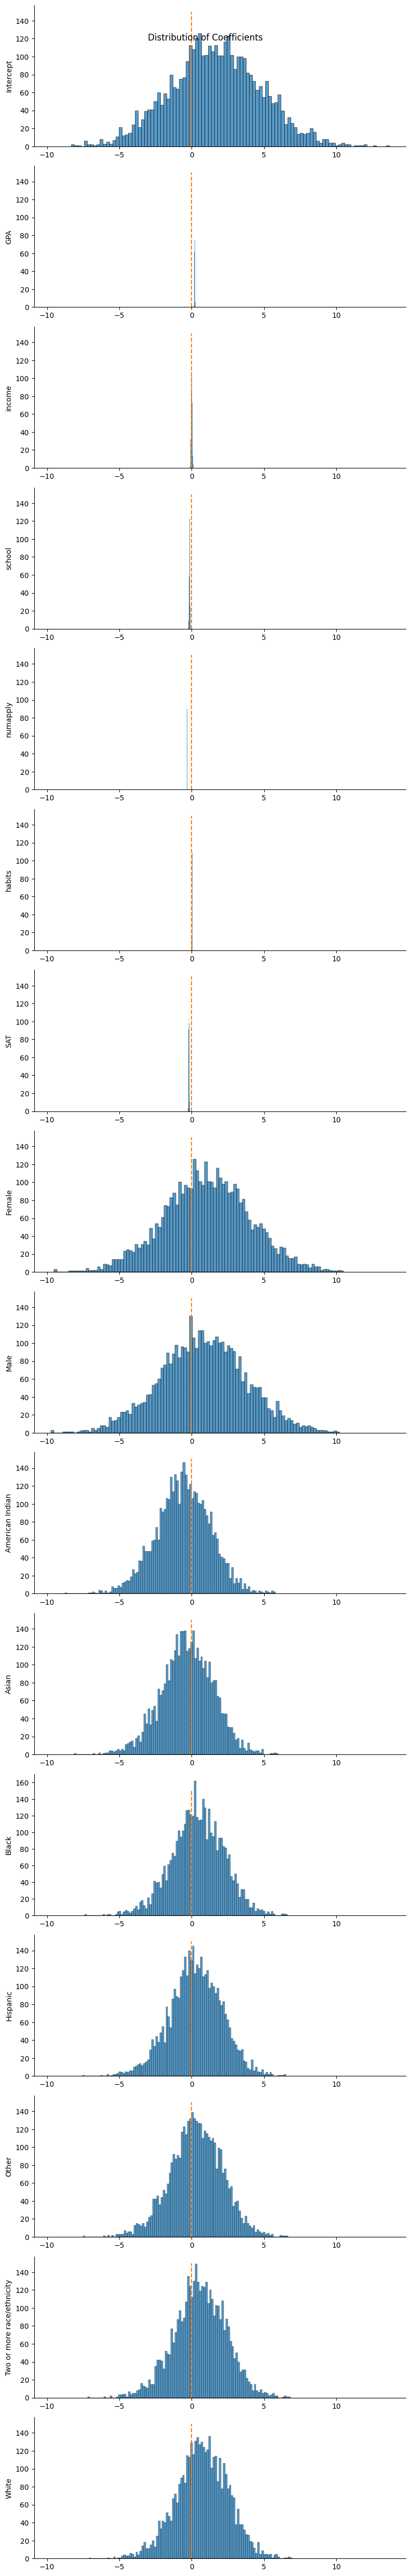

In [57]:
# plot_betas(fit)

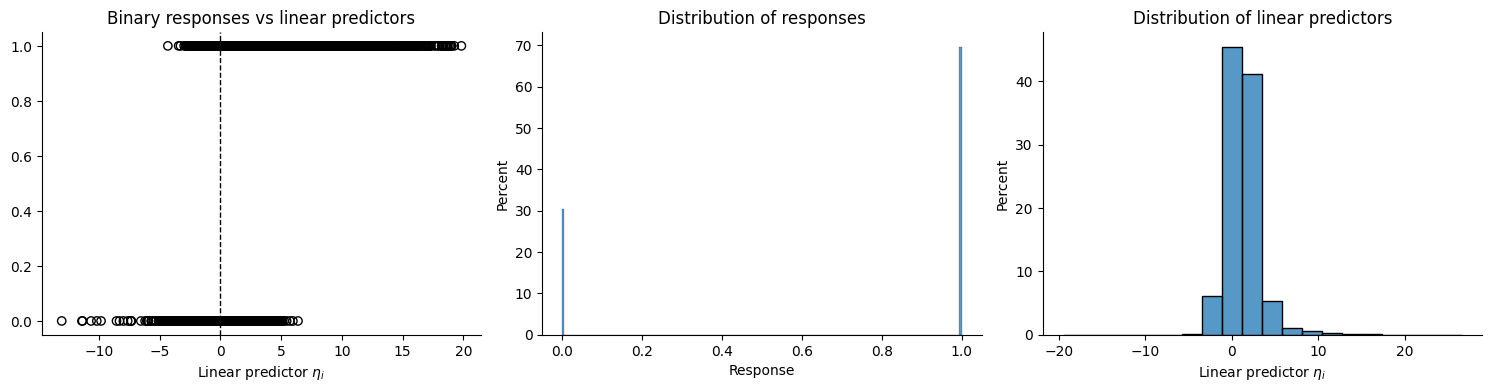

In [40]:
plt.figure(figsize=(15, 4))

plt.subplot(131)
plt.title('Binary responses vs linear predictors')
for sample_idx in range(10):
  # choose a random sample
  t = np.random.randint(0, 4000)
  plt.scatter(fit['eta'][:, t], fit['Y_tilde'][:, t], c='none', edgecolors='k')
sns.despine()
plt.axvline(0, c='k', lw=1, ls='--')
plt.xlabel('Linear predictor $\eta_i$')


plt.subplot(132)
plt.title('Distribution of responses')
sns.histplot(fit['Y_tilde'].flatten(), stat='percent')
sns.despine()
plt.xlabel('Response')

plt.subplot(133)
sns.histplot(fit['eta'].flatten(), bins=20, stat='percent')
sns.despine()
plt.xlabel('Linear predictor $\eta_i$')
plt.title('Distribution of linear predictors')

plt.tight_layout(pad=1)

In [41]:
np.random.seed(9001)
t = np.random.randint(4000)
print(classification_report(y_test, fit["y_new"][:, t]))

              precision    recall  f1-score   support

           0       0.46      0.47      0.46      3007
           1       0.77      0.77      0.77      6993

    accuracy                           0.68     10000
   macro avg       0.61      0.62      0.62     10000
weighted avg       0.68      0.68      0.68     10000

